In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
response = requests.get(url).text

In [3]:
soup = BeautifulSoup(response,'lxml')
Canada_Table = soup.find('table',{'class':'wikitable sortable'})

In [4]:
table_rows = Canada_Table.find_all('tr')

In [5]:
data = []
for row in table_rows:
    data.append([t.text.strip() for t in row.find_all('td')])

df = pd.DataFrame(data, columns= ['Postcode', 'Borough', 'Neighbourhood'])
df = df[df['Postcode'].notnull()]

In [6]:
df = df[df['Borough'] != 'Not assigned']

In [7]:
df = df.groupby(by = ['Postcode', 'Borough']).agg(lambda x:', '.join(x))

In [8]:
df.reset_index(level = ['Postcode', 'Borough'], inplace=True)

In [9]:
df.loc[df.Neighbourhood == 'Not assigned', 'Neighbourhood'] = df.Borough

In [10]:
df.shape

(103, 3)

In [11]:
Locations = pd.read_csv('https://cocl.us/Geospatial_data')

In [12]:
Mergeddf = df.merge(Locations, left_on='Postcode', right_on='Postal Code')

In [13]:
Mergeddf = Mergeddf.drop(['Postal Code'], axis=1)

In [14]:
!pip install folium

     |████████████████████████████████| 92kB 15.7MB/s eta 0:00:01


In [15]:
import folium

In [16]:
Boroughs_Only_Toronto = Mergeddf[Mergeddf['Borough'].str.contains("Toronto")].reset_index(drop=True)

In [17]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map([43.6532, -79.3832], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(Boroughs_Only_Toronto['Latitude'], Boroughs_Only_Toronto['Longitude'], Boroughs_Only_Toronto['Borough'], Boroughs_Only_Toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

In [18]:
# The code was removed by Watson Studio for sharing.

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
Toronto_venues = getNearbyVenues(names=Boroughs_Only_Toronto['Neighbourhood'],
                                   latitudes=Boroughs_Only_Toronto['Latitude'],
                                   longitudes=Boroughs_Only_Toronto['Longitude']
                                  )


The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [21]:
print(Toronto_venues.shape)
Toronto_venues.head()

(1700, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [22]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,56,56,56,56,56,56
"Brockton, Exhibition Place, Parkdale Village",22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,17,17,17,17,17,17
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",16,16,16,16,16,16
"Cabbagetown, St. James Town",46,46,46,46,46,46
Central Bay Street,84,84,84,84,84,84
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,15,15,15,15,15,15


In [23]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 234 uniques categories.


In [24]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]
Toronto_onehot.shape

(1700, 234)

In [25]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant,Restaurant,Gym,Breakfast Spot,Asian Restaurant,American Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Farmers Market,Beer Bar,Bakery,Steakhouse,Cheese Shop,Café,Bistro
2,"Brockton, Exhibition Place, Parkdale Village",Breakfast Spot,Café,Coffee Shop,Pet Store,Bar,Burrito Place,Restaurant,Caribbean Restaurant,Climbing Gym,Performing Arts Venue
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Farmers Market,Auto Workshop,Park,Pizza Place,Restaurant,Butcher,Burrito Place,Brewery,Skate Park
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Coffee Shop,Boat or Ferry,Plane,Sculpture Garden,Boutique,Airport Gate


In [28]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Toronto_merged = Boroughs_Only_Toronto

In [30]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

In [31]:
Toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Trail,Pub,Women's Store,Donut Shop,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Eastern European Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Ice Cream Shop,Yoga Studio,Brewery,Indian Restaurant,Sports Bar,Spa
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Park,Sandwich Place,Sushi Restaurant,Ice Cream Shop,Brewery,Liquor Store,Burrito Place,Fast Food Restaurant,Fish & Chips Shop,Italian Restaurant
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Cheese Shop,Fish Market,Bookstore,Brewery,Seafood Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,4,Construction & Landscaping,Park,Bus Line,Swim School,Women's Store,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


In [32]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map([43.6532, -79.3832], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

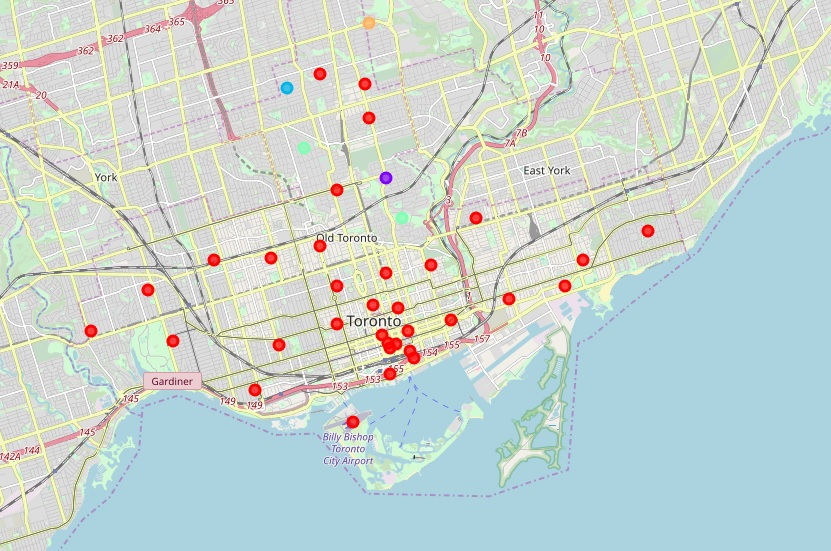